In [ ]:
%cd ..

/home/pg/projects/tennis-predictor


/home/pg/projects/tennis-predictor/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import sqlite3
import pandas as pd

# Data exploration

In [3]:
cnx = sqlite3.connect('./data/silver/tennis_atp/atpdatabase.db')

## Tables

In [4]:
# Create a cursor object
cursor = cnx.cursor()

# Execute the SQL command to list all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all results
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

player
matches
ranking


In [5]:
df_player = pd.read_sql_query("SELECT * FROM player LIMIT 5", cnx)
df_player

,id,firstName,lastName,hand,birth,country
0,player_id,name_first,name_last,hand,dob,ioc
1,100001,Gardnar,Mulloy,R,19131122,USA
2,100002,Pancho,Segura,R,19210620,ECU
3,100003,Frank,Sedgman,R,19271002,AUS
4,100004,Giuseppe,Merlo,R,19271011,ITA


In [6]:
# Execute the SQL command to list all tables
cursor.execute("SELECT COUNT(*) FROM player;")

# Fetch all results
res = cursor.fetchall()
print(res[0][0])

65990


In [7]:
df_matches = pd.read_sql_query("SELECT * FROM matches LIMIT 5", cnx)
df_matches

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-2029,Dublin,Grass,32,A,19680708,270,112411,,,...,,,,,,,,,,
1,1968-2029,Dublin,Grass,32,A,19680708,271,126914,,,...,,,,,,,,,,
2,1968-2029,Dublin,Grass,32,A,19680708,272,209523,,,...,,,,,,,,,,
3,1968-2029,Dublin,Grass,32,A,19680708,273,100084,,,...,,,,,,,,,,
4,1968-2029,Dublin,Grass,32,A,19680708,274,100132,,,...,,,,,,,,,,


In [8]:
df_matches.iloc[0]

tourney_id                  1968-2029
tourney_name                   Dublin
surface                         Grass
draw_size                          32
tourney_level                       A
tourney_date                 19680708
match_num                         270
winner_id                      112411
winner_seed                          
winner_entry                         
winner_name                Doug Smith
winner_hand                         U
winner_ht                            
winner_ioc                        AUS
winner_age                           
loser_id                       110196
loser_seed                           
loser_entry                          
loser_name            Peter Ledbetter
loser_hand                          U
loser_ht                             
loser_ioc                         IRL
loser_age                        24.0
score                         6-1 7-5
best_of                             3
round                             R32
minutes     

In [9]:
# Execute the SQL command to list all tables
cursor.execute("SELECT COUNT(*) FROM matches;")

# Fetch all results
res = cursor.fetchall()
print(res[0][0])

968207


In [10]:
df_ranking = pd.read_sql_query("SELECT * FROM ranking LIMIT 5", cnx)
df_ranking

,date,pos,player_id,pts
0,ranking_date,rank,player,points
1,20000110,1,101736,4135
2,20000110,2,102338,2915
3,20000110,3,101948,2419
4,20000110,4,103017,2184


In [11]:
# Execute the SQL command to list all tables
cursor.execute("SELECT COUNT(*) FROM ranking;")

# Fetch all results
res = cursor.fetchall()
print(res[0][0])

3292956


# ELO computation

For each date, for each player, I want to compute an ELO score.
I will use the following formula:
ELO_new = ELO_old + K * (S - E)
where:
- ELO_new is the new ELO score
- ELO_old is the old ELO score
- K is a constant (I will use 32)
- S is the score of the player (1 if he won, 0 if he lost)
- E is the expected score of the player (computed using the logistic function)
The logistic function is defined as follows:
$E = 1 / (1 + 10^{(ELO_{opponent} - ELO_{player}) / 400})$
where:
- ELO_opponent is the ELO score of the opponent
- ELO_player is the ELO score of the player
- 400 is a constant
The expected score E is the probability that the player wins the match.
If the player wins, S = 1, otherwise S = 0.

In [9]:
# Select oldest matches
query = "SELECT * FROM matches ORDER BY tourney_date, CAST(match_num AS INT)"  # Limit the number of matches to 100 for now

# Execute the query and load the result into a DataFrame
df = pd.read_sql_query(query, cnx)

# Print the DataFrame
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1877-540,Wimbledon,Grass,32,G,18770709,1,113987,,,...,,None,None,None,None,None,None,None,None,None
1,1877-540,Wimbledon,Grass,32,G,18770709,2,114146,,,...,,None,None,None,None,None,None,None,None,None
2,1877-540,Wimbledon,Grass,32,G,18770709,3,114147,,,...,,None,None,None,None,None,None,None,None,None
3,1877-540,Wimbledon,Grass,32,G,18770709,4,114149,,,...,,None,None,None,None,None,None,None,None,None
4,1877-540,Wimbledon,Grass,32,G,18770709,5,113953,,,...,,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968202,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
968203,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
968204,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
968205,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points


In [13]:
# Get unique ids
ids = set(df['winner_id'].unique()) | set(df['loser_id'].unique())

In [14]:

# Initialize the ELO scores at 1500
# Get unique ids
ids = set(df['winner_id'].unique()) | set(df['loser_id'].unique())
df_elo = pd.DataFrame([[p, '18770701', 1500] for p in ids], columns=['player_id', 'date', 'elo'])
df_elo.head()

,player_id,date,elo
0,,18770701,1500
1,115474,18770701,1500
2,123006,18770701,1500
3,127945,18770701,1500
4,125104,18770701,1500


In [15]:
# Filter df where tourney_date can be cast as int
df_filtered = df[df['tourney_date'].astype(str).str.isnumeric()]
df_filtered

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1877-540,Wimbledon,Grass,32,G,18770709,1,113987,,,...,,None,None,None,None,None,None,None,None,None
1,1877-540,Wimbledon,Grass,32,G,18770709,2,114146,,,...,,None,None,None,None,None,None,None,None,None
2,1877-540,Wimbledon,Grass,32,G,18770709,3,114147,,,...,,None,None,None,None,None,None,None,None,None
3,1877-540,Wimbledon,Grass,32,G,18770709,4,114149,,,...,,None,None,None,None,None,None,None,None,None
4,1877-540,Wimbledon,Grass,32,G,18770709,5,113953,,,...,,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968043,2024-7696,Next Gen Finals,Hard,8,F,20241218,396,210530,5,,...,49,40,9,12,4,6,122,493,20,2355
968044,2024-7696,Next Gen Finals,Hard,8,F,20241218,397,209950,1,,...,33,24,8,9,4,7,20,2355,48,1136
968045,2024-7696,Next Gen Finals,Hard,8,F,20241218,398,210530,5,,...,55,38,7,13,5,9,122,493,41,1245
968046,2024-7696,Next Gen Finals,Hard,8,F,20241218,399,211663,8,,...,35,19,7,9,10,14,145,409,128,471


In [16]:
from tqdm import tqdm

from tennis_predictor.helpers.elo import update_elo

# Update ELO scores
for row in tqdm(df.iterrows()):
    row = row[1]
    winner_id = row['winner_id']
    loser_id = row['loser_id']
    date = row['tourney_date']
    match_num = row['match_num']

    winner_elo = df_elo.loc[df_elo['player_id'] == winner_id, 'elo'].iloc[-1]  # Get the last ELO score of the player
    loser_elo = df_elo.loc[df_elo['player_id'] == loser_id, 'elo'].iloc[-1]  # Get the last ELO score of the player
    winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo)

    new_rows = pd.DataFrame([
        [winner_id, date, match_num, winner_new_elo], 
        [loser_id, date, match_num, loser_new_elo]
    ], columns=['player_id', 'date', 'match_num', 'elo'])
    df_elo = pd.concat([df_elo, new_rows], ignore_index=True)

593it [00:03, 150.13it/s]


KeyboardInterrupt: 

In [17]:
df_elo.tail()

,player_id,date,elo,match_num
38843,114663,18880820,1441.349997,12
38844,113989,18880820,1500.736307,13
38845,116673,18880820,1483.263693,13
38846,116882,18880820,1518.617965,14
38847,116893,18880820,1538.746057,14


## Evolution plot

/tmp/ipykernel_68854/3507554244.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_players['date'] = pd.to_datetime(df_top_players['date'])


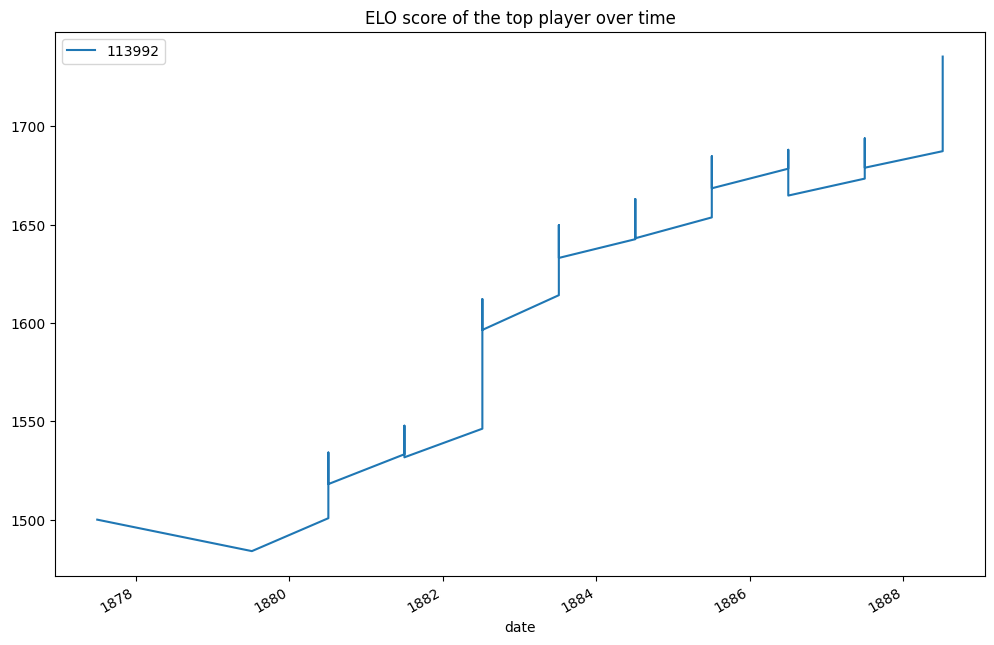

In [18]:
# I will now show the evolution of the ELO score of the top player over time.
import matplotlib.pyplot as plt

top_players = df_elo.groupby('player_id').last().sort_values('elo', ascending=False).head(1).index
df_top_players = df_elo[df_elo['player_id'].isin(top_players)]
df_top_players['date'] = pd.to_datetime(df_top_players['date'])
df_top_players = df_top_players.set_index('date')

plt.figure(figsize=(12, 8))
for player_id in top_players:
    df_top_players[df_top_players['player_id'] == player_id]['elo'].plot(label=player_id)
plt.legend()
plt.title('ELO score of the top player over time')
plt.show()

# Odds computation

### Join ELOs

In [11]:
df_elo_all = pd.read_csv('./data/silver/elo/elo_All.csv')
df_elo_all.head()

,player_id,date,tourney_id,match_num,elo,n_matches
0,106387,18770701,NaN,NaN,1500.0,0
1,112878,18770701,NaN,NaN,1500.0,0
2,110590,18770701,NaN,NaN,1500.0,0
3,210241,18770701,NaN,NaN,1500.0,0
4,109850,18770701,NaN,NaN,1500.0,0


In [12]:
df_elo_grass = pd.read_csv('./data/silver/elo/elo_Grass.csv')
df_elo_grass.head()

,player_id,date,tourney_id,match_num,elo,n_matches
0,100446,18770701,NaN,NaN,1500.0,0
1,112417,18770701,NaN,NaN,1500.0,0
2,105421,18770701,NaN,NaN,1500.0,0
3,100245,18770701,NaN,NaN,1500.0,0
4,114915,18770701,NaN,NaN,1500.0,0


In [13]:
df_matches = pd.read_sql_query("SELECT * FROM matches WHERE tourney_date >= '20240101' ORDER BY tourney_date, CAST(match_num AS INT)", cnx)

surface_type = 'Grass'
surface_condition = (df_matches['surface'] == surface_type) if surface_type != 'All' else True
df_matches_grass = df_matches[
    (df_matches['tourney_date'].astype(str).str.isnumeric())  # Remove bad rows
    & (df_matches['winner_id'].astype(str).str.isnumeric())
    & (df_matches['loser_id'].astype(str).str.isnumeric())
    & surface_condition  # Surface condition
]
df_matches_grass = df_matches_grass.reset_index(drop=True)
df_matches_grass

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2024-M-DC-2024-WG1-PO-PAK-IND-01,Davis Cup WG1 PO: PAK vs IND,Grass,4,D,20240203,1,106368,,,...,56,44,15,15,2,6,461,91,,
1,2024-M-DC-2024-WG1-PO-PAK-IND-01,Davis Cup WG1 PO: PAK vs IND,Grass,4,D,20240203,2,105502,,,...,27,23,16,10,3,5,,,,
2,2024-M-DC-2024-WG1-PO-PAK-IND-01,Davis Cup WG1 PO: PAK vs IND,Grass,4,D,20240203,4,144681,,,...,42,31,13,9,7,9,795,27,,
3,2024-M-ITF-AUS-2024-003,M25 Mildura,Grass,32,25,20240311,101,106109,1,,...,,,,,,,289,193,698,40
4,2024-M-ITF-AUS-2024-003,M25 Mildura,Grass,32,25,20240311,102,208055,,,...,,,,,,,575,62,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,2024-0315,Newport,Grass,32,A,20240715,296,210506,3,,...,46,31,11,10,4,6,61,816,91,668
728,2024-0315,Newport,Grass,32,A,20240715,297,124187,,WC,...,41,33,20,14,1,3,1187,7,99,626
729,2024-0315,Newport,Grass,32,A,20240715,298,106218,2,,...,41,30,18,14,6,10,46,1025,128,485
730,2024-0315,Newport,Grass,32,A,20240715,299,210506,3,,...,26,13,8,7,4,9,61,816,1187,7


In [15]:
winner_elos = []
winner_n_matchess = []
loser_elos = []
loser_n_matchess = []

winner_elos_grass = []
winner_n_matchess_grass = []
loser_elos_grass = []
loser_n_matchess_grass = []

for row in df_matches_grass.iterrows():
    row = row[1]
    winner_id = row['winner_id']
    loser_id = row['loser_id']
    date = row['tourney_date']
    match_num = row['match_num']

    # FIXME: if surface type is grass use elo grass elif is hard use elo hard elif...

    # Get the last ELO score of the player
    winner_elo, winner_n_matches = df_elo_all.loc[
        (df_elo_all['player_id'] == int(winner_id))
        & (df_elo_all['date'] <= int(date))
        & ~((df_elo_all['date'] == int(date)) & (df_elo_all['match_num'] >= int(match_num))),
        # FIXME: use tourney_id in case of multiple matches in the same day
        ['elo', 'n_matches']
    ].iloc[-1] 
    loser_elo, loser_n_matches = df_elo_all.loc[
        (df_elo_all['player_id'] == int(loser_id))
        & (df_elo_all['date'] <= int(date))
        & ~((df_elo_all['date'] == int(date)) & (df_elo_all['match_num'] >= int(match_num))),
        ['elo', 'n_matches']
    ].iloc[-1]
    winner_elos.append(winner_elo)
    winner_n_matchess.append(winner_n_matches)
    loser_elos.append(loser_elo)
    loser_n_matchess.append(loser_n_matches)

    # Get the last ELO score on Grass of the player
    winner_elo_grass, winner_n_matches_grass = df_elo_grass.loc[
        (df_elo_grass['player_id'] == int(winner_id))
        & (df_elo_grass['date'] <= int(date))
        & ~((df_elo_grass['date'] == int(date)) & (df_elo_grass['match_num'] >= int(match_num))),
        ['elo', 'n_matches']
    ].iloc[-1]
    loser_elo_grass, loser_n_matches_grass = df_elo_grass.loc[
        (df_elo_grass['player_id'] == int(loser_id))
        & (df_elo_grass['date'] <= int(date))
        & ~((df_elo_grass['date'] == int(date)) & (df_elo_grass['match_num'] >= int(match_num))),
        ['elo', 'n_matches']
    ].iloc[-1]
    winner_elos_grass.append(winner_elo_grass)
    winner_n_matchess_grass.append(winner_n_matchess_grass)
    loser_elos_grass.append(loser_elo_grass)
    loser_n_matchess_grass.append(loser_n_matchess_grass)

df_matches_grass['winner_elo'] = winner_elos
df_matches_grass['winner_n_matches'] = winner_n_matchess
df_matches_grass['loser_elo'] = loser_elos
df_matches_grass['loser_n_matches'] = loser_n_matchess
df_matches_grass['winner_elo_grass'] = winner_elos_grass
df_matches_grass['winner_n_matches_grass'] = winner_n_matchess_grass
df_matches_grass['loser_elo_grass'] = loser_elos_grass
df_matches_grass['loser_n_matches_grass'] = loser_n_matchess_grass
df_matches_grass.head()

: 

### Join players

In [14]:
df_odds_men = pd.read_excel('./data/bronze/tennis_odds/2024.xlsx')
df_odds_men = df_odds_men[df_odds_men['Surface'] == 'Grass']
df_odds_men.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
1808,43,Newport,Hall of Fame Championships,2024-07-19,ATP250,Outdoor,Grass,Quarterfinals,3,Eubanks C.,...,1.0,Completed,2.50,1.53,2.63,1.55,2.63,1.58,2.51,1.52
1809,43,Newport,Hall of Fame Championships,2024-07-19,ATP250,Outdoor,Grass,Quarterfinals,3,Giron M.,...,0.0,Completed,1.50,2.63,1.54,2.66,1.59,2.66,1.51,2.50
1810,43,Newport,Hall of Fame Championships,2024-07-20,ATP250,Outdoor,Grass,Semifinals,3,Michelsen A.,...,0.0,Completed,1.62,2.30,1.63,2.43,1.68,2.43,1.62,2.27
1811,43,Newport,Hall of Fame Championships,2024-07-20,ATP250,Outdoor,Grass,Semifinals,3,Giron M.,...,1.0,Completed,1.53,2.50,1.56,2.60,1.59,2.60,1.53,2.46
1812,43,Newport,Hall of Fame Championships,2024-07-21,ATP250,Outdoor,Grass,The Final,3,Giron M.,...,1.0,Completed,2.30,1.62,2.53,1.59,2.55,1.68,2.36,1.57


In [15]:
df_odds_women = pd.read_excel('./data/bronze/tennis_odds/women_2024.xlsx')
df_odds_women = df_odds_women[df_odds_women['Surface'] == 'Grass']
df_odds_women.tail()

,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
1550,31,London,Wimbledon,2024-07-10,Grand Slam,Outdoor,Grass,Quarterfinals,3,Krejcikova B.,...,0.0,Completed,2.75,1.44,3.01,1.44,3.01,1.46,2.83,1.43
1551,31,London,Wimbledon,2024-07-10,Grand Slam,Outdoor,Grass,Quarterfinals,3,Rybakina E.,...,0.0,Completed,1.29,3.75,1.27,4.26,1.33,4.26,1.29,3.70
1552,31,London,Wimbledon,2024-07-11,Grand Slam,Outdoor,Grass,Semifinals,3,Paolini J.,...,1.0,Completed,1.53,2.50,1.67,2.35,1.67,2.51,1.59,2.37
1553,31,London,Wimbledon,2024-07-11,Grand Slam,Outdoor,Grass,Semifinals,3,Krejcikova B.,...,1.0,Completed,4.50,1.20,5.61,1.18,5.66,1.23,4.95,1.18
1554,31,London,Wimbledon,2024-07-13,Grand Slam,Outdoor,Grass,The Final,3,Krejcikova B.,...,1.0,Completed,1.73,2.20,1.79,2.15,1.8,2.25,1.74,2.13


In [16]:
df_players = pd.read_sql_query("SELECT * FROM player", cnx)
df_players = df_players.iloc[1:,:]  # Remove the first row which is bad values
df_players.head()

,id,firstName,lastName,hand,birth,country
1,100001,Gardnar,Mulloy,R,19131122,USA
2,100002,Pancho,Segura,R,19210620,ECU
3,100003,Frank,Sedgman,R,19271002,AUS
4,100004,Giuseppe,Merlo,R,19271011,ITA
5,100005,Richard,Gonzalez,R,19280509,USA


In [17]:
df_players_young = df_players[df_players['birth'] >= '19700101']
df_players_young.head()

,id,firstName,lastName,hand,birth,country
644,100644,Alexander,Zverev,R,19970420,GER
1495,101495,Miguel,Tobon,R,20060619,COL
1680,101680,Zeeshan,Ali,R,19700101,IND
1681,101681,Chris,Wilkinson,R,19700105,GBR
1682,101682,David,Adams,R,19700105,RSA


#### Make short name

In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
from tennis_predictor.helpers.odds import make_shortname

df_players_short = make_shortname(df_players_young)
df_players_short

/home/pg/projects/tennis-predictor/src/tennis_predictor/helpers/odds.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shortName'] = (


,id,firstName,lastName,hand,birth,country,shortName
0,100644,Alexander,Zverev,R,19970420,GER,Zverev A.
1,101495,Miguel,Tobon,R,20060619,COL,Tobon M.
2,101680,Zeeshan,Ali,R,19700101,IND,Ali Z.
3,101681,Chris,Wilkinson,R,19700105,GBR,Wilkinson C.
4,101682,David,Adams,R,19700105,RSA,Adams D.
...,...,...,...,...,...,...,...
40985,213531,Jake,Van Emburgh,R,19980923,USA,Van Emburgh J.
40986,213553,Dmytro,Shirokyi,U,20060702,UKR,Shirokyi D.
40987,213608,Moise,Kouame,R,20090306,FRA,Kouame M.
40988,213626,Angel,Veliz,U,20080727,ECU,Veliz A.


#### Get id

In [77]:
df_odds_men.merge(df_players_short, left_on='Winner', right_on='shortName', how='left', suffixes=['', '_winner'])

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,MaxL,AvgW,AvgL,id,firstName,lastName,hand,birth,country,shortName
0,33,Stuttgart,Stuttgart Open,2024-06-10,ATP250,Outdoor,Grass,1st Round,3,Draper J.,...,4.17,1.25,3.86,207733,Jack,Draper,L,20011222,GBR,Draper J.
1,33,Stuttgart,Stuttgart Open,2024-06-10,ATP250,Outdoor,Grass,1st Round,3,Koepfer D.,...,2.12,1.76,2.02,136440,Dominik,Koepfer,L,19940429,GER,Koepfer D.
2,33,Stuttgart,Stuttgart Open,2024-06-10,ATP250,Outdoor,Grass,1st Round,3,Hanfmann Y.,...,2.30,1.66,2.18,105870,Yannick,Hanfmann,R,19911113,GER,Hanfmann Y.
3,33,Stuttgart,Stuttgart Open,2024-06-10,ATP250,Outdoor,Grass,1st Round,3,Medjedovic H.,...,2.38,1.61,2.28,209098,Hamad,Medjedovic,R,20030718,SRB,Medjedovic H.
4,33,Stuttgart,Stuttgart Open,2024-06-11,ATP250,Outdoor,Grass,1st Round,3,Musetti L.,...,2.22,1.72,2.10,207518,Lorenzo,Musetti,R,20020303,ITA,Musetti L.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,43,Newport,Hall of Fame Championships,2024-07-19,ATP250,Outdoor,Grass,Quarterfinals,3,Eubanks C.,...,1.58,2.51,1.52,111153,Christopher,Eubanks,R,19960505,USA,Eubanks C.
377,43,Newport,Hall of Fame Championships,2024-07-19,ATP250,Outdoor,Grass,Quarterfinals,3,Giron M.,...,2.66,1.51,2.50,106218,Marcos,Giron,R,19930724,USA,Giron M.
378,43,Newport,Hall of Fame Championships,2024-07-20,ATP250,Outdoor,Grass,Semifinals,3,Michelsen A.,...,2.43,1.62,2.27,210506,Alex,Michelsen,R,20040825,USA,Michelsen A.
379,43,Newport,Hall of Fame Championships,2024-07-20,ATP250,Outdoor,Grass,Semifinals,3,Giron M.,...,2.60,1.53,2.46,106218,Marcos,Giron,R,19930724,USA,Giron M.


In [78]:
df_odds_men

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
1404,33,Stuttgart,Stuttgart Open,2024-06-10,ATP250,Outdoor,Grass,1st Round,3,Draper J.,...,0.0,Completed,1.25,4.00,1.26,4.08,1.27,4.17,1.25,3.86
1405,33,Stuttgart,Stuttgart Open,2024-06-10,ATP250,Outdoor,Grass,1st Round,3,Koepfer D.,...,1.0,Completed,1.80,2.00,1.79,2.08,1.81,2.12,1.76,2.02
1406,33,Stuttgart,Stuttgart Open,2024-06-10,ATP250,Outdoor,Grass,1st Round,3,Hanfmann Y.,...,0.0,Completed,1.67,2.20,1.71,2.21,1.81,2.30,1.66,2.18
1407,33,Stuttgart,Stuttgart Open,2024-06-10,ATP250,Outdoor,Grass,1st Round,3,Medjedovic H.,...,1.0,Completed,1.57,2.38,1.65,2.31,1.68,2.38,1.61,2.28
1408,33,Stuttgart,Stuttgart Open,2024-06-11,ATP250,Outdoor,Grass,1st Round,3,Musetti L.,...,0.0,Completed,1.67,2.20,1.78,2.09,1.78,2.22,1.72,2.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,43,Newport,Hall of Fame Championships,2024-07-19,ATP250,Outdoor,Grass,Quarterfinals,3,Eubanks C.,...,1.0,Completed,2.50,1.53,2.63,1.55,2.63,1.58,2.51,1.52
1809,43,Newport,Hall of Fame Championships,2024-07-19,ATP250,Outdoor,Grass,Quarterfinals,3,Giron M.,...,0.0,Completed,1.50,2.63,1.54,2.66,1.59,2.66,1.51,2.50
1810,43,Newport,Hall of Fame Championships,2024-07-20,ATP250,Outdoor,Grass,Semifinals,3,Michelsen A.,...,0.0,Completed,1.62,2.30,1.63,2.43,1.68,2.43,1.62,2.27
1811,43,Newport,Hall of Fame Championships,2024-07-20,ATP250,Outdoor,Grass,Semifinals,3,Giron M.,...,1.0,Completed,1.53,2.50,1.56,2.60,1.59,2.60,1.53,2.46


In [46]:
df_players_young['firstName'].apply(lambda x: '.'.join([s[0] for s in x.split(' ') if len(s) > 0]) + '.')

644      A.
1495     M.
1680     Z.
1681     C.
1682     D.
         ..
65816    J.
65838    D.
65893    M.
65911    A.
65971    G.
Name: firstName, Length: 40990, dtype: object

In [26]:
df_players[['firstName', 'lastName']].head(10)

,firstName,lastName
0,name_first,name_last
1,Gardnar,Mulloy
2,Pancho,Segura
3,Frank,Sedgman
4,Giuseppe,Merlo
5,Richard,Gonzalez
6,Grant,Golden
7,Abe,Segal
8,Kurt,Nielsen
9,Istvan,Gulyas


In [29]:
df_odds_women[['Winner']].head(10)

,Winner
1250,Vekic D.
1251,Minnen G.
1252,Krunic A.
1253,Pegula J.
1254,Yuan Y.
1255,Osaka N.
1256,Andreescu B.
1257,Bektas E.
1258,Naef C.
1259,Alexandrova E.


## Make evaluation dataset

In [12]:
df_elo = pd.read_csv('./data/silver/elo.csv')
df_elo.tail()

,player_id,date,tourney_id,match_num,elo,n_matches
1917355,210506,20241218,2024-7696,398.0,2291.715784,200
1917356,211663,20241218,2024-7696,399.0,2152.120316,84
1917357,209414,20241218,2024-7696,399.0,2048.590657,272
1917358,211663,20241218,2024-7696,400.0,2169.305701,85
1917359,210530,20241218,2024-7696,400.0,2160.722488,141


In [13]:
# Filter df on tourney_date < 19810413
df_matches_grass = df_filtered[
    df_filtered['tourney_date'] == '19840528'
]
df_matches_grass

FileNotFoundError: [Errno 2] No such file or directory: './data/silver/elo.csv'

In [29]:
winner_elos = []
loser_elos = []
for row in df_matches_grass.iterrows():
    row = row[1]
    winner_id = row['winner_id']
    loser_id = row['loser_id']
    date = row['tourney_date']
    match_num = row['match_num']

    # Get the last ELO score of the player
    winner_elo = df_elo.loc[
        (df_elo['player_id'] == int(winner_id))
        & (df_elo['date'] <= int(date))
        & ~((df_elo['date'] == int(date)) & (df_elo['match_num'] >= int(match_num))),
        'elo'
    ].iloc[-1] 
    loser_elo = df_elo.loc[
        (df_elo['player_id'] == int(loser_id))
        & (df_elo['date'] <= int(date))
        & ~((df_elo['date'] == int(date)) & (df_elo['match_num'] >= int(match_num))),
        'elo'
    ].iloc[-1]
    winner_elos.append(winner_elo)
    loser_elos.append(loser_elo)

In [14]:
df_matches_grass['winner_elo'] = winner_elos
df_matches_grass['loser_elo'] = loser_elos

NameError: name 'evaluation_set' is not defined

In [23]:
from tennis_predictor.helpers.elo import compute_expected_winrate

df_matches_grass['winner_prob'] = df_matches_grass[['winner_elo', 'loser_elo']].apply(lambda row: compute_expected_winrate(row[0], row[1]), axis=1)
df_matches_grass['y'] = 1
df_matches_grass['y_hat'] = (df_matches_grass['winner_prob'] > 0.5).astype(int)

/tmp/ipykernel_68854/154308162.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  evaluation_set['winner_prob'] = evaluation_set[['winner_elo', 'loser_elo']].apply(lambda row: compute_expected_winrate(row[0], row[1]), axis=1)
/tmp/ipykernel_68854/154308162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_set['winner_prob'] = evaluation_set[['winner_elo', 'loser_elo']].apply(lambda row: compute_expected_winrate(row[0], row[1]), axis=1)
/tmp/ipykernel_68854/154308162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [24]:
df_matches_grass

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,winner_elo,loser_elo,winner_prob,y,y_hat
95936,1984-520,Roland Garros,Clay,128,G,19840528,1,100581,1,,...,,1,,,,2444.350726,1588.261746,0.992811,1,1
95937,1984-520,Roland Garros,Clay,128,G,19840528,2,100797,,,...,,58,,75,,1708.967801,1717.734547,0.487386,1,0
95938,1984-520,Roland Garros,Clay,128,G,19840528,3,100764,,,...,,,,62,,1644.723305,1812.151592,0.276119,1,0
95939,1984-520,Roland Garros,Clay,128,G,19840528,4,100611,,,...,,25,,,,1858.105527,1659.993929,0.757757,1,1
95940,1984-520,Roland Garros,Clay,128,G,19840528,5,100652,,,...,,65,,81,,1765.629673,1738.565096,0.538870,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96058,1984-520,Roland Garros,Clay,128,G,19840528,123,101062,4,,...,,4,,6,,2203.676568,2078.842906,0.672299,1,1
96059,1984-520,Roland Garros,Clay,128,G,19840528,124,100656,2,,...,,2,,7,,2310.705691,2074.760665,0.795468,1,1
96060,1984-520,Roland Garros,Clay,128,G,19840528,125,100581,1,,...,,1,,3,,2451.432611,2278.928642,0.729683,1,1
96061,1984-520,Roland Garros,Clay,128,G,19840528,126,100656,2,,...,,2,,4,,2317.250701,2214.163008,0.644150,1,1


In [28]:
from sklearn.metrics import accuracy_score, log_loss

## Evaluate

In [ ]:
from sklearn.metrics import accuracy_score, log_loss

In [26]:
sklearn_accuracy = accuracy_score(df_matches_grass['y'], df_matches_grass['y_hat'])
print(sklearn_accuracy)
sklearn_log_loss = log_loss(df_matches_grass['y'], df_matches_grass['winner_prob'], labels=[0, 1])
print(sklearn_log_loss)

0.7244094488188977
0.5262706976030929
